In [1]:
import os
import torch
import numpy as np
from minimodels.minimodel import data, model_trainer, model_builder

device = torch.device('cuda')
mouse_id = 0

data_path = 'minimodels/notebooks/data'
weight_path = 'minimodels/notebooks/checkpoints'
np.random.seed(1)

# build model
nlayers = 2
nconv1 = 16
nconv2 = 320
model, in_channels = model_builder.build_model(NN=6636, n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2)
model_name = model_builder.create_model_name("L1_A5", data.exp_date[mouse_id], n_layers=nlayers, in_channels=in_channels)

model_path = os.path.join(weight_path, model_name)
model = model.to(device)

model.load_state_dict(torch.load(model_path))
print('loaded model', model_path)

core shape:  torch.Size([1, 320, 33, 65])
input shape of readout:  (320, 33, 65)
model name:  l1a5_022723_2layer_16_320_clamp_norm_depthsep_pool.pt
loaded model minimodels/notebooks/checkpoints/l1a5_022723_2layer_16_320_clamp_norm_depthsep_pool.pt


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from utils import createFlowDataset, subps  
from glob import glob
from time import time

import sys

# Import the ResNet50 model
import torch.nn as nn


################# SET PARAMS ##########################
block = ['readout'] # select from readout
model_name = 'mini' # 
n_fmaps_to_sample = 40
samples_per_fmap = 2000
seed = 1

################ MORE PARAMS ##########################
# I suggest leaving the following unchanged for comparability
LAYER_TYPE = 'act'
MAX_SIDE = 32

# Flow stimuli parameters
scl_factor = 0.5
N_INSTANCES = 3
trial_len = 75 // 2  # Number of frames
stride = 1

## SAMPLING
fmap_samp_method = 'maxFr'
neur_samp_method = 'maxNr'


In [3]:
############## LOAD MODEL ############################

model.eval()
model.to(device)

# Define the input shape expected by the model
input_shape = (66, 130)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 2924596


tot_stims 88
frames_per_stim 37
*INSTANCE 0 .

..........
*INSTANCE 1 ...........
*INSTANCE 2 ...........


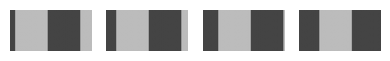

In [4]:

############# LOAD FLOW STIM FRAMES #################

orig_shape = (800, 600)
scl_factor = 0.4

mydirs = list(map(str, range(0, 360, 45)))
categories = ['grat_W12', 'grat_W1', 'grat_W2',
              'neg1dotflow_D1_bg', 'neg3dotflow_D1_bg', 'neg1dotflow_D2_bg', 'neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg', 'pos3dotflow_D1_bg', 'pos1dotflow_D2_bg', 'pos3dotflow_D2_bg']

topdir = 'flowstims'
NDIRS = len(mydirs)
tot_stims = len(categories) * NDIRS
print('tot_stims', tot_stims, flush=True)
frames_per_stim = (trial_len // stride)
print('frames_per_stim', frames_per_stim)

# Create flow datasets (placeholder function)
flow_datasets = createFlowDataset(categories, topdir, mydirs, orig_shape, input_shape,
                                  scl_factor, N_INSTANCES, trial_len, stride)

# Show example of sequence of frames generated for a stimulus trial
n_frames_to_show = 4
interval = 8

f, axes = subps(1, n_frames_to_show, 1, 1)
for i in range(n_frames_to_show):
    ax = axes[i]
    img = flow_datasets[0][i * interval].copy().reshape(input_shape)
    ax.imshow(img, vmin=0, vmax=255, cmap='gray')
    ax.axis('off')

f.tight_layout()
plt.show()

In [5]:

####################### COMPUTE ################

def reshape_flow_img(raveled_1chan_img):
    img = raveled_1chan_img.reshape(input_shape)
    img = np.stack([img], axis=0)  # Convert to 3 channels
    return img

# Prepare data processing
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

TOL = 0

n_orig_imgs = tot_stims
n_shifts = frames_per_stim
n_shifted_imgs = n_orig_imgs * n_shifts

# Batches for images and shifts
maxBatchsize = 8  # Max number of images to be used as input simultaneously
nBatches = int(np.ceil(n_shifted_imgs / float(maxBatchsize)))

print('tot # of images:', n_orig_imgs, '*', n_shifts, '=', n_shifted_imgs)
print('batchsize', maxBatchsize, '-- # of batches:', nBatches)

layer_outputs = []
instance_layer_outputs = []

for li in range(1):
    shape = [n_shifted_imgs] + [6636, 1, 1]
    layer_outputs.append(np.zeros(shape, dtype='float32'))
    shape_inst = np.append([N_INSTANCES], shape)
    instance_layer_outputs.append(np.zeros(shape_inst, dtype='float32'))


for insti in range(N_INSTANCES):
    extX = flow_datasets[insti]
    assert extX.shape[0] == n_shifted_imgs

    print('INSTANCE', insti)
    start0 = time()
    layer_output = []
    for li in range(1):
        layer_output.append([])

    for bb in range(nBatches):
        start = time()
        print(bb, end=' ', flush=True)

        # Prepare batch
        batch_images = []
        for im in extX[bb * maxBatchsize: (bb + 1) * maxBatchsize]:
            img = reshape_flow_img(im)
            #img = Image.fromarray(np.uint8(np.transpose(img, (1, 2, 0))))
            #img = preprocess(img)
            batch_images.append(torch.Tensor(img))
        batch = torch.stack(batch_images).to(device)

        with torch.no_grad():
            BATCH_SIZE = batch.shape[0]
            output = model(batch)
            print(f"Output shape: {output.shape}")

        # Collect outputs per layer
        for li in range(1):
            """# Crop the output if needed
            h, w, c = all_layer_spacedims[li]
            out_pad = out_pads[li]
            if output.ndim == 4:
                # output shape: (batch_size, channels, height, width)
                output_cropped = output[:, :, out_pad: out_pad + h, out_pad: out_pad + w]
                # Rearrange to (batch_size, height, width, channels)
                output_cropped = np.transpose(output_cropped, (0, 2, 3, 1))
            else:
                output_cropped = output  # For dense layers"""

            layer_output[li].append(output.cpu())

        print('(%.1fs) ' % (time() - start), end='', flush=True)
    print(' Tot time = %.1f' % (time() - start0), flush=True)

    # After processing all batches for this instance, concatenate outputs
    for li in range(1):
        # print(li)
        print([l.shape for l in layer_output[li]])
        layer_output[li] = np.expand_dims(np.expand_dims(np.concatenate(layer_output[li], axis=0), axis=2), axis=3)
        print(layer_output[li].shape)
        print(layer_outputs[li].shape)
        layer_outputs[li] += layer_output[li]
        instance_layer_outputs[li][insti] = layer_output[li]


# Average over instances
for li in range(1):
    layer_outputs[li] /= N_INSTANCES

tot # of images: 88 * 37 = 3256
batchsize 8 -- # of batches: 407
INSTANCE 0
0 Output shape: torch.Size([8, 6636])
(0.3s) 1 Output shape: torch.Size([8, 6636])
(0.0s) 2 Output shape: torch.Size([8, 6636])
(0.0s) 3 Output shape: torch.Size([8, 6636])
(0.0s) 4 Output shape: torch.Size([8, 6636])
(0.0s) 5 Output shape: torch.Size([8, 6636])
(0.0s) 6 Output shape: torch.Size([8, 6636])
(0.0s) 7 Output shape: torch.Size([8, 6636])
(0.0s) 8 Output shape: torch.Size([8, 6636])
(0.0s) 9 Output shape: torch.Size([8, 6636])
(0.0s) 10 Output shape: torch.Size([8, 6636])
(0.0s) 11 Output shape: torch.Size([8, 6636])
(0.0s) 12 Output shape: torch.Size([8, 6636])
(0.0s) 13 Output shape: torch.Size([8, 6636])
(0.0s) 14 Output shape: torch.Size([8, 6636])
(0.0s) 15 Output shape: torch.Size([8, 6636])
(0.0s) 16 Output shape: torch.Size([8, 6636])
(0.0s) 17 Output shape: torch.Size([8, 6636])
(0.0s) 18 Output shape: torch.Size([8, 6636])
(0.0s) 19 Output shape: torch.Size([8, 6636])
(0.0s) 20 Output shap

KeyboardInterrupt: 

In [6]:
print(layer_outputs[0].shape)

(3256, 6636, 1, 1)


In [7]:
################### SUMMARIZE ACTIVITY ###########

print('Activities per img:', end=' ')
all_neurons_maxs = []
all_neurons_means = []
all_per_img_output = []
for li in range(1):
    print(li, end='', flush=True)
    layer_output_ = layer_outputs[li].copy()

    layer_output_[layer_output_ < 0] = 0

    nfmaps = layer_output_.shape[3]
    # Reshape to [n_orig_imgs, n_shifts, nfmaps, -1]
    orig_per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    orig_per_img_output = np.moveaxis(orig_per_img_output, 1, -1)

    # Normalize each image by the max
    layer_output_ /= np.maximum(layer_output_.max((1, 2, 3), keepdims=True), 1e-8)

    per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    per_img_output = np.moveaxis(per_img_output, 1, -1)

    tot_n_neurons = np.prod(layer_output_.shape[1:])

    neurons_maxs = np.zeros(per_img_output.shape[1:3])
    neurons_means = np.zeros(per_img_output.shape[1:3])

    for imi in range(n_orig_imgs):
        im_avgs = per_img_output[imi].mean(2)  # Averaging across time
        neurons_maxs = np.maximum(neurons_maxs, im_avgs)
        neurons_means += im_avgs
    neurons_means /= n_orig_imgs

    idxs = neurons_maxs.mean(1).argsort()

    if li == 0:
        all_neurons_maxs = neurons_maxs
        all_neurons_means = neurons_means
        all_per_img_output = orig_per_img_output
    else:
        all_neurons_maxs = np.concatenate([all_neurons_maxs, neurons_maxs], 0)
        all_neurons_means = np.concatenate([all_neurons_means, neurons_means], 0)
        all_per_img_output = np.concatenate([all_per_img_output, orig_per_img_output], 1)

Activities per img: 0

In [8]:
############# SAMPLE NEURONS ###########

nfmaps, n_neurons_per_fmap = all_neurons_maxs.shape
layer_is_per_fmap = np.concatenate([li * np.ones(nf) for li, nf in enumerate([1])])
np.random.seed(seed)

maxsmean = all_neurons_maxs.mean(1)
nonzero_indices = (~np.isclose(maxsmean, 0)).sum()
n_fmaps_to_sample_ = min(n_fmaps_to_sample, nonzero_indices)
print(n_fmaps_to_sample)
if fmap_samp_method == 'maxFr':
    probabilities = maxsmean / maxsmean.sum()
    top_fmaps = np.random.choice(range(nfmaps), n_fmaps_to_sample_, replace=False, p=probabilities)
else:
    raise ValueError('Invalid fmap_samp_method')

# Pick active neurons in each of these feature maps
sampled_neurons = []

samples_per_fmap = min(samples_per_fmap, all_neurons_means.shape[1])
print(samples_per_fmap)
for fi in top_fmaps:
    if neur_samp_method == 'maxNr':
        neuron_vals = all_neurons_maxs[fi]
        nonzero_neurons = (~np.isclose(neuron_vals, 0)).sum()
        samples_per_fmap_ = min(samples_per_fmap, nonzero_neurons)
        probabilities = neuron_vals / neuron_vals.sum()
        top_nis = np.random.choice(range(n_neurons_per_fmap), samples_per_fmap_, replace=False, p=probabilities)
    else:
        raise ValueError('Invalid neur_samp_method')
    sampled_neurons += list(fi * n_neurons_per_fmap + top_nis)
sampled_neurons = np.array(sampled_neurons)
n_neurons_to_pick = len(sampled_neurons)
print(n_neurons_to_pick)

40
2000
2000


In [10]:

######### BUILD TENSOR ##########

def get_neuron_pos(ni):
    """From sampled indices ni, get original indices back (layer index, fmap, posi, posj, raveled_idx)"""
    fi = ni // n_neurons_per_fmap
    li = int(layer_is_per_fmap[fi])
    ij = ni % n_neurons_per_fmap
    h, w, _ = (6636, 1, 1)
    ii = ij // w
    jj = ij % w
    return li, fi, ii, jj, ij

assert n_orig_imgs // NDIRS == len(categories)

tensorX = np.zeros((n_neurons_to_pick, len(categories), NDIRS, n_shifts))
neurons_used = np.empty((n_neurons_to_pick, 5), dtype='int')

# Collect PSTs for those sampled neurons
for nii, ni in enumerate(sampled_neurons):
    li, fi, ii, jj, posi = get_neuron_pos(ni)
    neurons_used[nii] = [li, fi, ii, jj, posi]

    for cati in range(len(categories)):
        pst = all_per_img_output[cati * NDIRS: (cati + 1) * NDIRS, fi, posi, :]
        tensorX[nii, cati] = pst

SUFFIX = f"{model_name}_{LAYER_TYPE}_i{N_INSTANCES}_n{n_neurons_to_pick}_SCL{str(scl_factor).replace('.', '_')}_TL{trial_len}_{'_'.join(block)}_{fmap_samp_method}_{neur_samp_method}"
if seed > 0:
    SUFFIX += f'_seed{seed}'

print(SUFFIX)

directory = '../data/sampled_data'
os.makedirs(directory, exist_ok=True)

if os.path.exists(f'../data/sampled_data/tensor4d_{SUFFIX}.npy'):
    print("Files already exist, please delete them to prevent conflicts.")
else:
    
    np.save(f'../data/sampled_data/tensor4d_{SUFFIX}.npy', tensorX)
    print(f'tensor4d_{SUFFIX}.npy Saved.')

    np.save(f'../data/sampled_data/neurons_used_{SUFFIX}.npy', neurons_used)
    print(f'neurons_used_{SUFFIX}.npy Saved.')

mini_act_i3_n2000_SCL0_4_TL37_readout_maxFr_maxNr_seed1
tensor4d_mini_act_i3_n2000_SCL0_4_TL37_readout_maxFr_maxNr_seed1.npy Saved.
neurons_used_mini_act_i3_n2000_SCL0_4_TL37_readout_maxFr_maxNr_seed1.npy Saved.
